In [1]:
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile as tiff 
import cv2
from skimage.transform import resize
import seaborn as sns
from skimage.color import rgb2gray
import tensorflow_io as tfio
import pandas as pd; pd.options.mode.chained_assignment = None
from tensorflow.keras.applications import EfficientNetB6

from PIL import Image, ImageOps
from skimage import color

sns.set_style('white')
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
BASE_PATH = "D:Dataset/dataset/hubmap-organ-segmentation/"
train = pd.read_csv(BASE_PATH+'train_fix.csv')
test = pd.read_csv(BASE_PATH+'test.csv')

In [13]:
def get_label(target_path):
    target = tf.io.read_file(target_path)
    target = tf.io.decode_jpeg(target, channels=3)  # 2진법 8비트로 해독 (0~255)
    target = tf.image.resize(target, [size, size])  # 사이즈 조절 (3 채널만 가능하다)
    target = target[:, :, 0]
    target = tf.expand_dims(target, 2)
    target = tf.where(target>0,1,0)
    return target

def get_image(file_path):
    image = tf.io.read_file(file_path)
    image = tfio.experimental.image.decode_tiff(image)
    image = image[:, :, :3]
    image = tf.image.resize(image, [size, size]) 
    image = image / 255.
    return image

def process_path(file_path, target_path):  # image, label
    label = get_label(target_path)
    img = get_image(file_path)
    return img, label


def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=10)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

simple_aug = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomFlip("horizontal_and_vertical")
    ]
)

In [4]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

def weighted_loss(y_true, y_pred):
    # Calculate the base loss
    ce = K.sparse_categorical_crossentropy(tf.cast(y_true, tf.float32), y_pred)
    # Apply the weights
    one_weight = 1.0
    zero_weight = 1e-2
    weight_vector = tf.cast(y_true, tf.float32) * one_weight + (1. - tf.cast(y_true, tf.float32)) * zero_weight
    weight_vector = K.squeeze(weight_vector, axis=-1)
    weighted_ce = weight_vector * ce
    # Return the mean error
    return K.mean(weighted_ce)

In [5]:
from IPython.display import clear_output
from tensorflow.keras import backend as K

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
        
    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
        plt.tight_layout()
        plt.show()

In [6]:
organs = train.organ.unique()

In [7]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()
from segmentation_models import Unet, FPN
from segmentation_models.utils import set_trainable

Segmentation Models: using `keras` framework.


In [8]:
prostate_df = train[train["organ"]=="prostate"]
list_ds = tf.data.Dataset.from_tensor_slices( (prostate_df["train_img_path"].values, prostate_df["mask_img_path"].values) ) # (x,y) = (image, label)
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False) # 데이터 셔플 / 랜덤

# DS split (10%)
val_size = int(len(list_ds)*0.1) # 1147 # 10%는 valid set
train_ds = list_ds.skip(val_size) # 10% 를 넘김 # 90%
valid_ds = list_ds.take(val_size) # 10% 를 가짐 
NUM_TRAIN = tf.data.experimental.cardinality(train_ds).numpy()
NUM_VALID = tf.data.experimental.cardinality(valid_ds).numpy()
print(NUM_TRAIN, NUM_VALID)

84 9


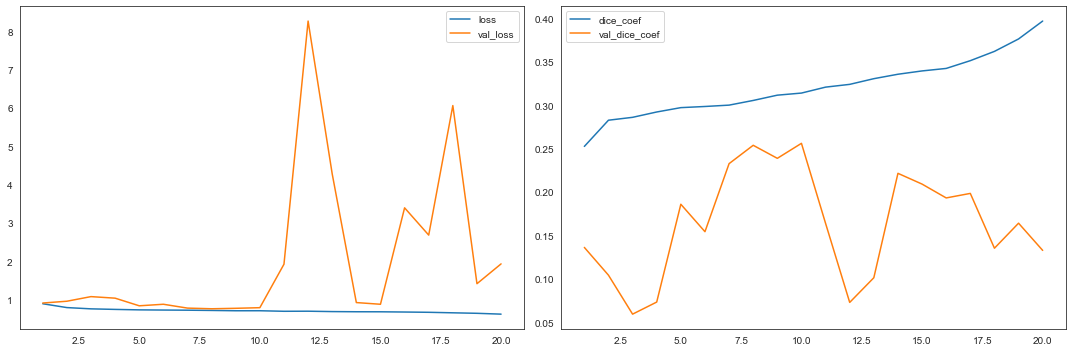


Epoch 20: val_dice_coef did not improve from 0.25610
84/84 [==============================] - 21s 251ms/step - loss: 0.6193 - dice_coef: 0.3969 - val_loss: 1.9310 - val_dice_coef: 0.1328


In [9]:
batch_size = 1
AUTOTUNE = tf.data.experimental.AUTOTUNE
NAME = ["B6"]
SIZE = [480]
EPOCHS = [20]

for name, size, epoch in zip(NAME, SIZE,EPOCHS):
    
    # 데이터셋 호출!
    # img_path, label -> img, one_hot vector label
    train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    valid_ds = valid_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    
    # 증강
    train_ds = train_ds.map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTOTUNE)
    
    # 하드웨어 성능향상 + 배치
    train_ds = configure_for_performance(train_ds) 
    valid_ds = configure_for_performance(valid_ds)
    
    #모델 호출!
    model = Unet('efficientnetb6',input_shape=(size, size, 3), classes=1, activation='sigmoid', encoder_weights=None)
    model.compile(loss=bce_dice_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=[dice_coef])
    
    # 콜백!
    
    save_best = tf.keras.callbacks.ModelCheckpoint(f"model/{name}_model_prostate.h5", monitor='val_dice_coef', save_best_only=True, mode='max', verbose=True,)
    
    # 학습!
    print("----------------------- "+name+ " prostate -----------------------")
    model.fit(train_ds,validation_data=valid_ds,epochs=epoch, use_multiprocessing=False, callbacks=[PlotLearning(), save_best])

In [8]:
prostate_df = train[train["organ"]=="prostate"]
list_ds = tf.data.Dataset.from_tensor_slices( (prostate_df["train_img_path"].values, prostate_df["mask_img_path"].values) ) # (x,y) = (image, label)
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False) # 데이터 셔플 / 랜덤

# DS split (10%)
val_size = int(len(list_ds)*0.1) # 1147 # 10%는 valid set
train_ds = list_ds.skip(val_size) # 10% 를 넘김 # 90%
valid_ds = list_ds.take(val_size) # 10% 를 가짐 
NUM_TRAIN = tf.data.experimental.cardinality(train_ds).numpy()
NUM_VALID = tf.data.experimental.cardinality(valid_ds).numpy()
print(NUM_TRAIN, NUM_VALID)

84 9


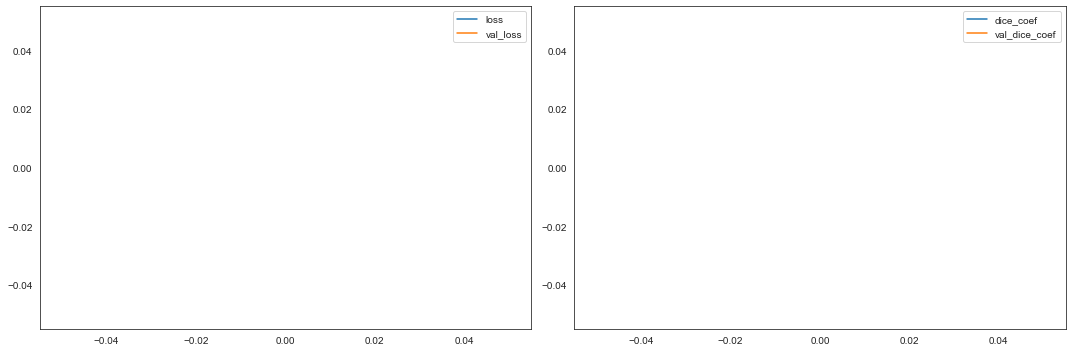


Epoch 20: val_dice_coef did not improve from -inf
84/84 [==============================] - 20s 236ms/step - loss: nan - dice_coef: nan - val_loss: nan - val_dice_coef: nan


In [9]:
batch_size = 1
AUTOTUNE = tf.data.experimental.AUTOTUNE
NAME = ["B6"]
SIZE = [480]
EPOCHS = [20]

for name, size, epoch in zip(NAME, SIZE,EPOCHS):
    
    # 데이터셋 호출!
    # img_path, label -> img, one_hot vector label
    train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    valid_ds = valid_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    
    # 증강
    train_ds = train_ds.map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTOTUNE)
    
    # 하드웨어 성능향상 + 배치
    train_ds = configure_for_performance(train_ds) 
    valid_ds = configure_for_performance(valid_ds)
    
    #모델 호출!
    model = Unet('efficientnetb6',input_shape=(size, size, 3), classes=1, activation='sigmoid', encoder_weights=None)
    model.compile(loss=bc, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=[dice_coef])
    
    # 콜백!
    
    save_best = tf.keras.callbacks.ModelCheckpoint(f"model/{name}_model_prostate_WL.h5", monitor='val_dice_coef', save_best_only=True, mode='max', verbose=True,)
    
    # 학습!
    print("----------------------- "+name+ " prostate -----------------------")
    model.fit(train_ds,validation_data=valid_ds,epochs=epoch, use_multiprocessing=False, callbacks=[PlotLearning(), save_best])